## Face Detection

The recent work on Retina-Net object by [Tsung-Yi Lin et al](https://arxiv.org/abs/1708.02002) implemented in by [Fizyr](https://github.com/fizyr/keras-retinanet) is explored in this task.

The dataset is based on FDDB dataset. And for training, 1000 face images are used and for validation, 200 face images are used.

The codes below is modified from the Fizyr reference.


In [1]:
%matplotlib inline
import numpy as np
import cv2
import os
import time

import keras
import keras.preprocessing.image

import tensorflow as tf

from keras_retinanet.models.resnet import ResNet50RetinaNet
from keras_retinanet.preprocessing.csv_generator import CSVGenerator
import keras_retinanet
import keras_resnet
import keras_resnet.models
import keras_retinanet.models.retinanet
from keras_retinanet.models.resnet import custom_objects

Using TensorFlow backend.


In [2]:
print(keras.__version__)

2.0.9


### Define the model

In [3]:
def ResNet50RetinaNet1(inputs, num_classes, weights='imagenet', *args, **kwargs):
    image = inputs
    
    resnet = keras_resnet.models.ResNet50(image, include_top=False, freeze_bn=True)
    model = keras_retinanet.models.retinanet.retinanet_bbox(inputs=inputs, num_classes=num_classes, backbone=resnet, *args, **kwargs)

    # load pretrained imagenet weights?
    weights_path = ''
    if weights == 'imagenet':
        weights_path = 'ResNet-50-model.keras.h5'
    else:
        weights_path = weights
    model.load_weights(weights_path, by_name=True)
    return model

In [4]:
def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)


def create_model(num_classes, weights='imagenet'):
    image = keras.layers.Input((None, None, 3))
    return ResNet50RetinaNet1(image, num_classes=num_classes, weights=weights)

In [5]:
keras.backend.tensorflow_backend.set_session(get_session())

# create image data generator objects
train_image_data_generator = keras.preprocessing.image.ImageDataGenerator(
    horizontal_flip=True,
)

train_path1 = 'd:/data/fddb/train.csv'
val_path1 = 'd:/data/fddb/valid.csv'
class_path2 = 'd:/data/fddb/class.csv'
batch_size1 = 4

# create a generator for training data
train_generator = CSVGenerator(
    csv_data_file=train_path1,
    csv_class_file=class_path2,
    image_data_generator=train_image_data_generator,
    batch_size=batch_size1
)

test_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

# create a generator for testing data
test_generator = CSVGenerator(
    csv_data_file=val_path1,
    csv_class_file=class_path2,
    image_data_generator=test_image_data_generator,
    batch_size=batch_size1
)

num_classes = train_generator.num_classes()

In [7]:
# create the model
print('Creating model, this may take a second...')
model = create_model(num_classes=num_classes, weights='imagenet')

# compile model (note: set loss to None since loss is added inside layer)
model.compile(
    loss={
        'regression'    : keras_retinanet.losses.smooth_l1(),
        'classification': keras_retinanet.losses.focal()
    },
    optimizer=keras.optimizers.adam(lr=1e-5, clipnorm=0.001)
)

# print model summary
print(model.summary())


Creating model, this may take a second...
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
___________________________________________________________________

C:\Users\ku\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: UserWarning: Output "nms" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "nms" during training.
  # This is added back by InteractiveShellApp.init_path()


In [8]:
model.load_weights('w1.h5')


# start training
try:
    history = model.fit_generator(
        generator=train_generator,
        steps_per_epoch=train_generator.size() // batch_size1,
        epochs=20,
        verbose=1,
        max_queue_size=20,
        validation_data=test_generator,
        validation_steps=test_generator.size() // batch_size1 if test_generator else 0,
        callbacks=[
            keras.callbacks.ModelCheckpoint(os.path.join('snapshots', 'resnet50_csv_best.h5'), monitor='val_loss', verbose=1, save_best_only=True),
            keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=2, verbose=1, mode='auto', epsilon=0.0001, cooldown=0, min_lr=0),
        ],
    )
except KeyboardInterrupt:
    print('stopping..')
    pass

# store final result too
model.save(os.path.join('snapshots','resnet50_csv_final.h5'))

Epoch 1/20
134/134 [==============================] - 180s 1s/step - loss: 0.0795 - regression_loss: 0.0440 - classification_loss: 0.0355 - val_loss: 0.1567 - val_regression_loss: 0.0664 - val_classification_loss: 0.0903
Epoch 2/20
134/134 [==============================] - 100s 744ms/step - loss: 0.0776 - regression_loss: 0.0436 - classification_loss: 0.0340 - val_loss: 0.1411 - val_regression_loss: 0.0581 - val_classification_loss: 0.0829
Epoch 3/20
 12/134 [=>............................] - ETA: 1:21 - loss: 0.0687 - regression_loss: 0.0422 - classification_loss: 0.0264stopping..


### Testing

using example coco dataset 2017

In [6]:
model = keras.models.load_model(os.path.join('snapshots','resnet50_csv_final.h5'), custom_objects=custom_objects)


C:\Users\ku\Anaconda3\lib\site-packages\keras\models.py:270: UserWarning: Output "non_maximum_suppression_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "non_maximum_suppression_1" during training.
  sample_weight_mode=sample_weight_mode)


In [27]:
# create image data generator object
val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

# create a generator for testing data
val_generator = CSVGenerator(
    'valid.csv',
    'class.csv',
    val_image_data_generator,
    batch_size=1,
)
index = 2

In [28]:

# load image
image = val_generator.load_image(index)
# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = val_generator.preprocess_image(image)
image, scale = val_generator.resize_image(image)
annotations = val_generator.load_annotations(index)
index += 1

# process image
start = time.time()
_, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

# correct for image scale
detections[:, :4] /= scale

processing time:  0.3456284999847412


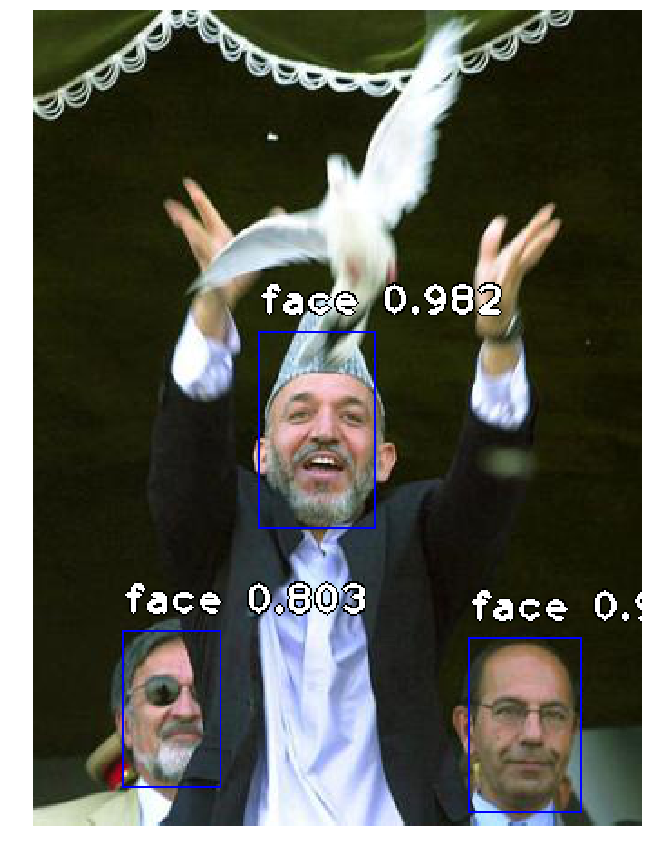

In [29]:
import matplotlib.pyplot as plt

# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.5:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 1)
    caption = "{} {:.3f}".format(val_generator.label_to_name(label), score)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
# visualize annotations
# for annotation in annotations:
#     label = int(annotation[4])
#     b = annotation[:4].astype(int)
#     cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
#     caption = "{}".format(val_generator.label_to_name(label))
#     cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
#     cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

More challenging ..

In [30]:
# load image
image = cv2.imread('000000018380.jpg')
#val_generator.load_image(index)
# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = val_generator.preprocess_image(image)
image, scale = val_generator.resize_image(image)
annotations = val_generator.load_annotations(index)
index += 1

# process image
start = time.time()
_, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]

# correct for image scale
detections[:, :4] /= scale

processing time:  0.15865063667297363


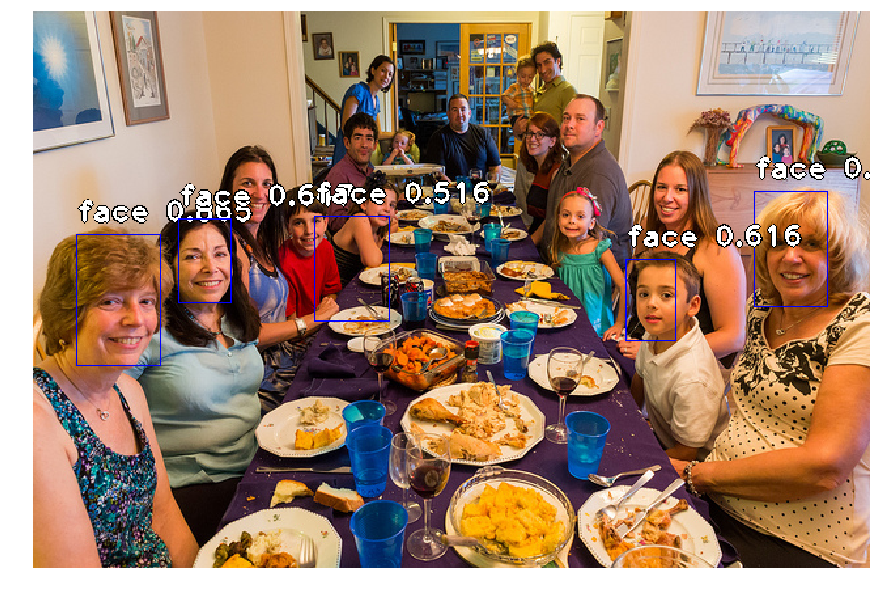

In [31]:
import matplotlib.pyplot as plt

# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.5:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 1)
    caption = "{} {:.3f}".format(val_generator.label_to_name(label), score)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
# visualize annotations
# for annotation in annotations:
#     label = int(annotation[4])
#     b = annotation[:4].astype(int)
#     cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
#     caption = "{}".format(val_generator.label_to_name(label))
#     cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
#     cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

### Conclusions

The deep learning can be used to perform face detection. In the last result, we need to increase number of training data to include different face image size. 

With this face detection, we can link-up to the face hallucination.